# Heisenberg 4 Sites &mdash; Analytical Forms

## Import packages

In [1]:
import time, os

import numpy as np
import sympy as sp
from scipy import linalg, sparse

from openfermion.ops import FermionOperator as FO, QubitOperator as QO
from openfermion.linalg import get_sparse_operator, get_ground_state
from openfermion.utils import anticommutator, commutator, save_operator, count_qubits, is_hermitian, hermitian_conjugated

from IPython.display import display, Math, Markdown, Latex, HTML

import matplotlib as mpl
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({
    #"text.usetex": True,
    #"font.family": "serif",
    #"font.serif": ["Computer Modern Roman", "Times", "Palatino"],
    #"font.size": 16,
})
#mpl.rcParams['font.family'] = ['serif', 'sans-serif']
##mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage[T1]{fontenc}'
#mpl.rcParams['text.latex.unicode'] = True
from mpl_toolkits.axes_grid1 import Grid

from qiskit.quantum_info import Statevector

from qutip import Qobj, about, basis, simdiag

## Define Hamiltonian and SWAP operators

In [3]:
# Heisenberg 4-site Hamiltonian terms in OpenFermion qubit operator form
Lsite = 4
Ham = {}
edges = [(1,2), (2,3), (3,4), (4,1)]  #site index 1--4, but OpenFermion index 0--3
for ii,jj in edges:
    Ham[(ii,jj)] = QO(f'X{ii-1} X{jj-1}') + QO(f'Y{ii-1} Y{jj-1}') + QO(f'Z{ii-1} Z{jj-1}')

# Full Hamiltonian in qubit operator
HQ = QO()  #initialize with zero operator
for k,v in Ham.items():
    HQ += v
# Convert to sparse numerical matrix, then to numpy array (.A), then to real part (XX, YY, ZZ are purely real)
HM = get_sparse_operator(HQ, n_qubits=4).A.real
eigE_H4, eigV_H4 = np.linalg.eigh(HM)
print('4-site Heisenberg Hamiltonian eigenenergy:',eigE_H4.round(6), sep='\n')

4-site Heisenberg Hamiltonian eigenenergy:
[-8. -4. -4. -4. -0. -0.  0.  0.  0.  0.  0.  4.  4.  4.  4.  4.]


In [4]:
# SWAP operators s_ij
Swaps = {}
for k,v in Ham.items():
    Swaps[k] = 0.5*(v + QO(()))

Swaps[(2,4)] = 0.5*(QO('X1 X3') + QO('Y1 Y3') + QO('Z1 Z3') + QO(()))
Swaps[(1,3)] = 0.5*(QO('X0 X2') + QO('Y0 Y2') + QO('Z0 Z2') + QO(()))

## Diagonalization in $(\mathbf{S}^2,S_z)$ symmetry basis

In [5]:
# Define symmetry operators in OpenFermion qubit operator form
S2, Sz, Sx, Sy = QO(), QO(), QO(), QO()  #(S^2, Sz, Sx, Sy) qubit operators
for ii in range(4):
    Sz += QO(f'Z{ii}', 0.5)
    Sx += QO(f'X{ii}', 0.5)
    Sy += QO(f'Y{ii}', 0.5)
S2 = Sx*Sx + Sy*Sy + Sz*Sz
#symmetry operators must commute with the full Hamiltonian
#print(commutator(S2, HQ), commutator(Sz, HQ), commutator(S2, Sz), sep='\n')

# Convert to numpy array
SzM = get_sparse_operator(Sz,n_qubits=4).A.real
S2M = get_sparse_operator(S2,n_qubits=4).A.real
s24 = get_sparse_operator(Swaps[(2,4)],n_qubits=4).A.real

# Find simultaneous eigenvectors using QuTiP
eigEsym, eigVsym = simdiag([Qobj(HM), Qobj(S2M), Qobj(SzM), Qobj(s24)])
#good quantum numbers are all integers here, so round off numerical noise
eigEsym = eigEsym.round(12).T
#eigenvectors here should be real (imaginary parts are numerical noise); and transpose (.T) to column-vector notation
eigVsym = np.array(eigVsym)[:,:,0].T.real
print('En s(s+1) sz   s24')
for ii in range(2**Lsite):
    print('{:2.0f}   {:2.0f}   {:2.0f}   {:2.0f}'.format(*eigEsym[ii,:]))

En s(s+1) sz   s24
-8    0    0    1
-4    2   -1    1
-4    2    0    1
-4    2    1    1
-0   -0    0   -1
 0    2   -1   -1
-0    2   -1    1
 0    2   -0   -1
 0    2   -0    1
-0    2    1   -1
-0    2    1    1
 4    6   -2    1
 4    6   -1    1
 4    6    0    1
 4    6    1    1
 4    6    2    1


## Compute <0|GSP(α,Eₛ)|0>

In [7]:
#step 1: compute products of projectors and the exponents of Gaussian weights (α independent part)

b_list = [np.binary_repr(n,width=8) for n in range(2**8)]  #bit strings b₇b₆b₅b₄b₃b₂b₁b₀
vb_list = [] #bit vectors [b₀,b₁,b₂,b₃,b₄,b₅,b₆,b₇] <- bit strings b₇b₆b₅b₄b₃b₂b₁b₀
hij_list = [(4, 1), (2, 3), (3, 4), (1, 2), (4, 1), (2, 3), (3, 4), (1, 2)]  #hᵢⱼ=πᵢⱼ
GSP_list = []  # VTA

wt_list = []
Eshift = 0.5 #must < -6 to remain in the s=0 subspace
sqsum = lambda vb: (0.5*Eshift - 2 + 2*np.sum(vb))**2
gsfun = lambda a, s: np.exp(-2.*a*a*s)

Nps = 0
for nn, b in enumerate(b_list):
    vb = np.array(list(reversed(b)),dtype=int)
    sign_list = -vb*2 + 1.
    #print(sign_list)
    op = QO(())
    for ii in range(8):
        s = sign_list[ii]
        op *= 0.5*(1 + Swaps[hij_list[ii]]*s)  #building op from right to left
        if op == QO():
            #print(sign_list, nn, ii) #print(ii,':',op,'\n')
            break
    if op != QO(): #only store nonzero product of projectors πᵢⱼ
        Nps += 1
        #print(Nps, nn, sign_list)
        vb_list.append(vb)
        wt = (sqsum(vb[np.ix_([0,3,5,6])]) +
              sqsum(vb[np.ix_([0,2,5,7])]) +
              sqsum(vb[np.ix_([1,2,4,7])]) +
              sqsum(vb[np.ix_([1,3,4,6])]) )
        wt_list.append(wt)
        GSP_list.append(op)
print(Nps)

76


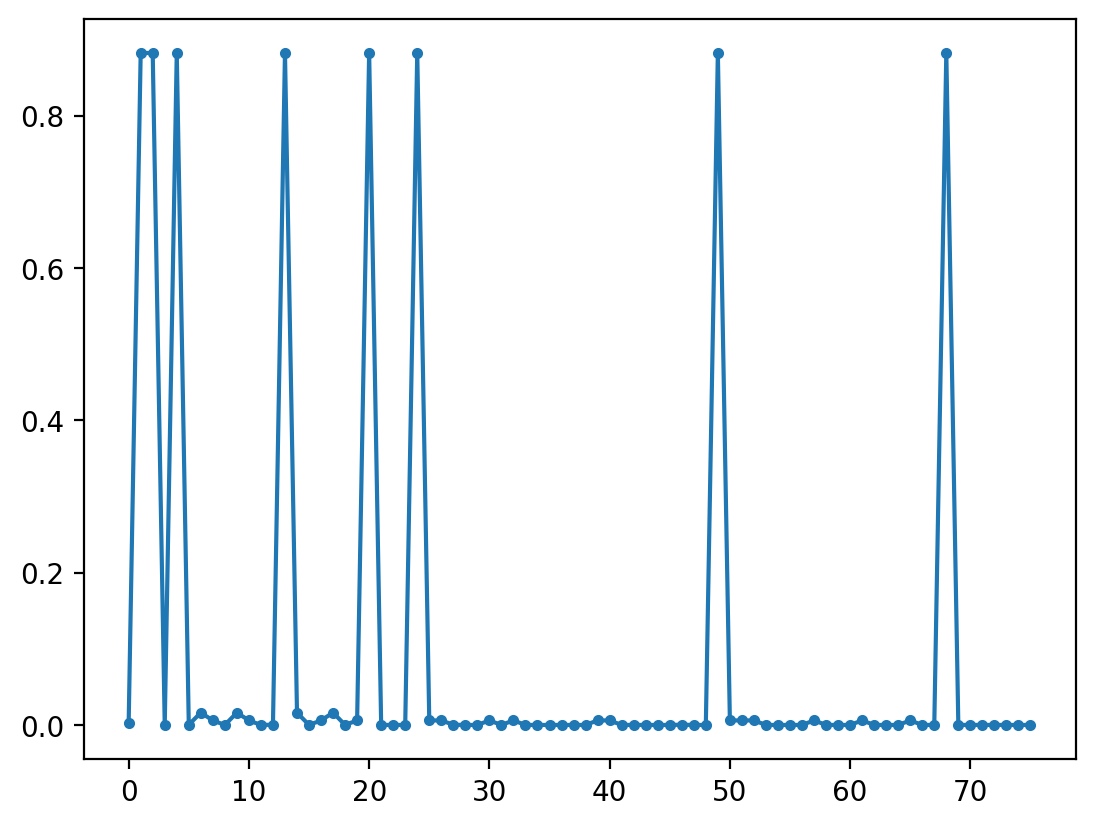

[G,H]==0? False
[S²,H]==0? True
[S²,G]==0? True
[Sz,G]==0? True


In [8]:
#step 2: compute VTA=<0|GSP(α,Eₛ)|0>

α = 0.5
gswt_list = [gsfun(α,s) for s in wt_list] #Gaussian weights
plt.plot(gswt_list,'.-')
plt.show()

#compute GSP
#GSP = QO() #initialize with zero operator
#for wt, op in zip(gswt_list,GSP_list):
#    GSP += wt*op
GSP = np.dot(gswt_list,GSP_list)
GM = get_sparse_operator(GSP,n_qubits=4).A.real  #numpy array (dense matrix format); elements of πᵢⱼ are all real

#check if commute
print('[G,H]==0?',np.linalg.norm(GM@HM - HM@GM,ord='fro')<1e-15)
print('[S²,H]==0?',np.linalg.norm(S2M@HM - HM@S2M,ord='fro')<1e-15)
print('[S²,G]==0?',np.linalg.norm(S2M@GM - GM@S2M,ord='fro')<1e-15)
print('[Sz,G]==0?',np.linalg.norm(SzM@GM - GM@SzM,ord='fro')<1e-15)

In [9]:
#step 3: transform VTA=<0|GSP(α,Eₛ)|0> to the symmetry eigenbasis

GMtf = eigVsym.T @ GM @ eigVsym
idx = np.where(abs(GMtf)>1e-14)
print(idx[0],idx[1],GMtf[idx],sep='\n')
print()

S2Mtf = eigVsym.T @ S2M @ eigVsym
idx = np.where(abs(S2Mtf)>1e-14)
print(idx[0],idx[1],S2Mtf[idx],sep='\n')

[ 0  0  1  2  3  4  4  5  6  7  8  9 10 11 12 13 14 15]
[ 0  4  1  2  3  0  4  5  6  7  8  9 10 11 12 13 14 15]
[-6.08468542e-05 -1.91162900e-01  5.95424567e-03  5.95424567e-03
  5.95424567e-03  1.91162900e-01  6.62085266e-01  4.44361201e-01
  4.44368567e-01  4.44362055e-01  4.44365831e-01  4.41723243e-01
  4.44368585e-01  2.18749112e-03  2.18749112e-03  2.18749112e-03
  2.18749112e-03  2.18749112e-03]

[ 1  2  3  5  6  7  8  9 10 11 12 13 14 15]
[ 1  2  3  5  6  7  8  9 10 11 12 13 14 15]
[2.         2.         2.         1.99996677 1.99999992 1.99997061
 1.9999876  1.98809393 2.         6.         6.         6.
 6.         6.        ]
